In [7]:
!pip install gymnasium

UnboundLocalError: local variable 'child' referenced before assignment

--- Logging error ---
Traceback (most recent call last):
  File "/home/rhs/miniconda3/envs/RL/lib/python3.10/site-packages/IPython/utils/_process_posix.py", line 151, in system
    child = pexpect.spawn(self.sh, args=['-c', cmd])  # Vanilla Pexpect
  File "/home/rhs/miniconda3/envs/RL/lib/python3.10/site-packages/pexpect/pty_spawn.py", line 205, in __init__
    self._spawn(command, args, preexec_fn, dimensions)
  File "/home/rhs/miniconda3/envs/RL/lib/python3.10/site-packages/pexpect/pty_spawn.py", line 303, in _spawn
    self.ptyproc = self._spawnpty(self.args, env=self.env,
  File "/home/rhs/miniconda3/envs/RL/lib/python3.10/site-packages/pexpect/pty_spawn.py", line 315, in _spawnpty
    return ptyprocess.PtyProcess.spawn(args, **kwargs)
  File "/home/rhs/miniconda3/envs/RL/lib/python3.10/site-packages/ptyprocess/ptyprocess.py", line 289, in spawn
    os.execv(command, argv)
  File "/home/rhs/miniconda3/envs/RL/lib/python3.10/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/pydev

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import imageio
from IPython.display import Video
import torch
import numpy as np
from agent import QLearningAgent,DQNAgent,REINFORCE,ActorCritic
import cv2


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
env = gym.make("LunarLander-v3", render_mode="rgb_array")
observation, info = env.reset(seed=42)

def show_env(env):
    frame = env.render()
    plt.imshow(frame)
    plt.axis('off')
    plt.show()

def plot(x,ylabel='Loss'):
    # === Plot ===
    plt.xlabel('Episode')
    plt.ylabel(ylabel)
    plt.plot(range(len(x)), x)
    plt.show()

def test_agent(agent, env="LunarLander-v3", num_envs=8, num_episodes=1000):
    """
    并行测试智能体在多个环境中的表现，不进行学习和探索。
    输入:
        agent: 智能体对象，需实现 get_action 方法
        num_envs: 并行环境数量
        num_episodes: 总测试回合数
    输出:
        绘制奖励分布图
        """
        # 这里必须是工厂函数列表
    envs =  gym.make_vec(env, num_envs=num_envs, vectorization_mode="sync")
    total_rewards = []
    episodes_per_env = num_episodes // num_envs
    agent.eval()

    for _ in range(episodes_per_env):
        obs, infos = envs.reset()
        dones = [False] * num_envs
        rewards = [0.0] * num_envs

        while not all(dones):
            actions, _ = agent.get_action(obs)
            obs, step_rewards, terminated, truncated, infos = envs.step(actions)
            for i in range(num_envs):
                if not dones[i]:
                    rewards[i] += step_rewards[i]
                    dones[i] = terminated[i] or truncated[i]
        total_rewards.extend(rewards)

    plt.figure(figsize=(8,5))
    plt.hist(total_rewards, bins=30, color='skyblue', edgecolor='black')
    plt.xlabel('reward')
    plt.ylabel('episodes')
    plt.title(f'{num_episodes} episodes-reward distribution')
    plt.show()
    
def save_video(agent, env):
    frames = []
    obs, infos = env.reset()
    sum_reward = 0
    agent.eval()
    while True:
        action, prob = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action.item())
        obs = next_obs
        sum_reward += reward

        frame = env.render()
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        cv2.putText(frame, f"Reward: {sum_reward:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 
                    1, (0, 255, 0), 2, cv2.LINE_AA)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

        if terminated or truncated:
            break

    # 保存为视频
    imageio.mimsave('reinforce_lunarlander.mp4', frames, fps=30)
    Video('reinforce_lunarlander.mp4', embed=True)

In [3]:
print('动作空间：', env.action_space)
print('观察空间: ', env.observation_space) # 8个值的区间
# 观察就是部分状态

动作空间： Discrete(4)
观察空间:  Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)


In [ ]:
frames = []

while True:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    frame = env.render()
    frames.append(frame)
    if terminated or truncated:
        break

# 保存为视频
imageio.mimsave('lunarlander.mp4', frames, fps=30)
Video('lunarlander.mp4', embed=True)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [3]:
agent = QLearningAgent(
        state_size=8,
        action_size=2,
        device=device)
agent.qnet.to(device)  # 模型转到GPU

episodes = 1000
loss_history = []

for episode in range(episodes):
    state, info = env.reset()
    total_loss, cnt = 0, 0
    terminated = False
    truncated = False

    while not (terminated or truncated):
        action = agent.getAction(state)
        next_state, reward, terminated, truncated, info = env.step(action)

        loss = agent.update(state, action, reward, next_state, terminated or truncated)
        total_loss += loss
        cnt += 1
        state = next_state

    average_loss = total_loss / cnt
    if episode % 10 == 0 :
        print(f'Episode {episode}, Average Loss: {average_loss:.4f}')
    loss_history.append(average_loss)

TypeError: MLP_QNet.__init__() got an unexpected keyword argument 'input_size'

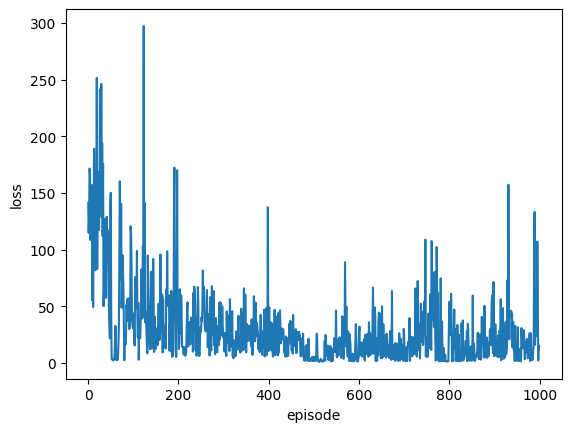

In [ ]:
plt.xlabel('episode')
plt.ylabel('loss')
plt.plot(range(len(loss_history)), loss_history)
plt.show()

In [ ]:
# 保存权重
torch.save(agent.qnet.state_dict(), "lunar_lander.pth")

In [3]:
agent = DQNAgent(
    lr=0.0001,
    epsilon=0.5,
    batch_size=128,
    buffer_size=10000,
    action_size=4,
    device=device,
    use_cnn=False
    )

episodes = 600
loss_history = []
sync_interval = 20 # todo 减小

for episode in range(episodes):
    state, info = env.reset()
    total_loss, cnt = 0, 0
    done = False
    sum_reward = 0
    
    while not done:
        action, Q = agent.get_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        loss = agent.update(state, action, reward, next_state, done)
        total_loss += loss
        cnt += 1
        state = next_state
        sum_reward += reward

    average_loss = total_loss / cnt

    if episode % sync_interval == 0:
        agent.sync_qnet()
    if episode % 10 == 0:
        print("episode :{}, total reward : {:.1f}, loss : {:.4f}".format(episode, sum_reward, average_loss))
    loss_history.append(average_loss)

episode :0, total reward : -284.1, loss : 0.0000
episode :10, total reward : -147.7, loss : 2.6516
episode :20, total reward : -158.7, loss : 2.1397
episode :30, total reward : -203.4, loss : 2.2034
episode :40, total reward : -197.7, loss : 2.3048
episode :50, total reward : -331.2, loss : 2.2576
episode :60, total reward : -627.8, loss : 2.4149
episode :70, total reward : -572.1, loss : 2.8041
episode :80, total reward : -201.3, loss : 2.8424
episode :90, total reward : -251.7, loss : 3.1206
episode :100, total reward : -143.0, loss : 3.3070
episode :110, total reward : -222.7, loss : 3.3809
episode :120, total reward : -551.5, loss : 3.3339
episode :130, total reward : -46.0, loss : 3.5285
episode :140, total reward : -95.6, loss : 3.3006
episode :150, total reward : -342.9, loss : 2.9467
episode :160, total reward : -428.7, loss : 2.6872
episode :170, total reward : -219.7, loss : 2.5091
episode :180, total reward : -675.7, loss : 2.2979
episode :190, total reward : -46.8, loss : 2

In [ ]:
torch.save(agent.pi.state_dict(), "models/reinforce_lunar_lander2.pth")

In [6]:
test_agent(agent,env="LunarLander-v3",num_envs=128,num_episodes=1000)

AttributeError: 'DQNAgent' object has no attribute 'eval'

In [4]:
agent = REINFORCE(
    lr=0.001,
    action_size=4)
episodes=5000

In [5]:
for episode in range(episodes):
    state, info = env.reset()
    terminated = False
    truncated = False
    sum_reward = 0

    while not (terminated or truncated): 
        action, prob = agent.get_action(state)
        next_state, reward, terminated, truncated, info = env.step(action.item())

        agent.add(reward, prob)
        state = next_state
        sum_reward += reward

    loss = agent.update()

    if episode % 100 == 0:
        print("episode :{}, total reward : {:.1f}, loss : {:.4f}".format(episode, sum_reward, loss))

episode :0, total reward : -390.2, loss : -15518.8662
episode :100, total reward : -43.2, loss : -2519.6123
episode :200, total reward : -119.4, loss : -4404.1289
episode :300, total reward : -199.5, loss : -7612.1357
episode :400, total reward : -168.6, loss : -8533.9863
episode :500, total reward : -261.2, loss : -7945.4648
episode :600, total reward : 4.1, loss : 317.0540
episode :700, total reward : -210.0, loss : -8332.9424
episode :800, total reward : -176.9, loss : -5786.4248
episode :900, total reward : 18.6, loss : 665.7236
episode :1000, total reward : -45.8, loss : -1363.5060
episode :1100, total reward : -203.2, loss : -6445.9028
episode :1200, total reward : 13.8, loss : -596.4177
episode :1300, total reward : -42.0, loss : -1516.6227
episode :1400, total reward : 278.2, loss : 3426.5449
episode :1500, total reward : -180.6, loss : -152.2810
episode :1600, total reward : 60.6, loss : 608.4059
episode :1700, total reward : 184.6, loss : 1822.5947
episode :1800, total reward

In [8]:
torch.save(agent.pi.state_dict(), "models/reinforce_lunar_lander2.pth")

In [6]:
agent.pi.load_state_dict(torch.load("models/reinforce_lunar_lander2.pth"))

<All keys matched successfully>

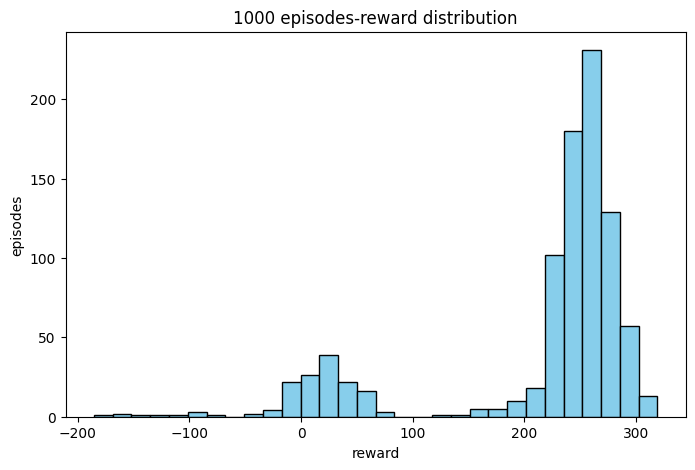

In [6]:
test_agent(agent,env="LunarLander-v3",num_envs=128,num_episodes=1000)

In [ ]:
save_video(agent, env)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [ ]:
agent = ActorCritic(
    action_size=4,
    device='cpu',
    lr_pi=0.001,
    lr_v=0.005,
    gamma=0.98
)
reward_history = []
episodes=1000

for episode in range(episodes):
    state, info = env.reset()
    done = False
    sum_reward = 0

    while not done: 
        action, action_probs = agent.get_action(state)
        next_state, reward,  terminated, truncated, info = env.step(action)
        
        done = (terminated or truncated)
        agent.update(state, action, action_probs, reward, next_state, done)
        state = next_state
        sum_reward += reward
        

    reward_history.append(sum_reward)

    if episode % 100 == 0:
        print("episode :{}, total reward : {:.1f}".format(episode, sum_reward))

episode :0, total reward : -125.4
episode :100, total reward : -87.7
episode :200, total reward : -98.7
episode :300, total reward : -99.6
episode :400, total reward : -113.3
episode :500, total reward : -148.3
episode :600, total reward : -103.3
episode :700, total reward : -137.2
episode :800, total reward : -139.2
episode :900, total reward : -36.5


In [ ]:
test_agent(agent, env)

NameError: name 'test_agent' is not defined

In [ ]:
from stable_baselines3 import A2C
model = A2C("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=1_000_000)

vec_env = model.get_env()
obs = vec_env.reset()
for i in range(1000):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, info = vec_env.step(action)
    # VecEnv resets automatically
    # if done:
    #   obs = vec_env.reset()
    print(reward)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 127      |
|    ep_rew_mean        | -375     |
| time/                 |          |
|    fps                | 344      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.11    |
|    explained_variance | -0.0343  |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 3.88     |
|    value_loss         | 14       |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 130      |
|    ep_rew_mean        | -267     |
| time/                 |          |
|    fps                | 343      |
|    iterations         | 200      |
|    time_elapsed